In [1]:
import numpy as np
import stim

# function to get the i'th bit of an integer n
def get_bit(n, i):
    return (n >> i) & 1

In [2]:
QRM_X_CHECKS = [
    [1,3,5,7,9,11,13,15],
    [2,3,6,7,10,11,14,15],
    [4,5,6,7,12,13,14,15],
    [8,9,10,11,12,13,14,15]
]

QRM_Z_CHECKS = [
    [ 1, 3, 5, 7, 0, 0],
    [ 3, 2, 7, 6, 0, 0],
    [ 2, 6,14,10, 0, 0],
    [ 6,14,12, 4, 0, 0],
    [13,12, 4, 5, 0, 0],
    [12, 8, 0,13, 9, 0],
    [ 8, 9,10,11, 0, 0],
    [ 9, 1,11, 3, 0, 0],
    [ 5, 7,13,15, 0, 0],
    [10,11,15,14, 0, 0],
    # redundancies
    [ 4, 5, 0, 0, 7, 6],
    [14, 0, 8, 0,10,12],
    [ 0, 0, 9, 1, 5,13],
    [ 0,10, 2, 0,11, 3],
    [ 0,15, 6, 0,14, 7],
    [15,13, 0, 0,12,14],
    [ 7, 0, 3, 0,15,11],
    [11, 0, 0, 9,13,15]
]

QRM_META_CHECKS = [
    [ 1,18, 8, 9],
    [ 1,18,13,17],
    [ 2,10,14,15],
    [ 2,10, 3,17],
    [ 5,15, 4, 9],
    [ 5,15,11,16],
    [ 7,16, 6,10],
    [ 7,16,12,18],
]

In [3]:
# solving m * n linear system in GF(2)
def solve_gf2(A, b):
    A = np.array(A, dtype=np.int8)
    b = np.array(b, dtype=np.int8)
    n = A.shape[1]
    m = A.shape[0]

    # augment the matrix
    Ab = np.hstack((A, b.reshape(-1, 1)))

    # perform Gaussian elimination
    for i in range(min(m, n)):
        if Ab[i, i] == 0:
            for j in range(i + 1, m):
                if Ab[j, i] == 1:
                    Ab[[i, j]] = Ab[[j, i]]
                    break
        for j in range(m):
            if j != i and Ab[j, i] == 1:
                Ab[j] ^= Ab[i]

    return Ab[:, -1]

In [4]:
import numpy as np

def solve_gf2(A, b):
    """
    Solve A x = b over GF(2).
    Returns a particular solution x (free variables set to 0).
    Raises ValueError if the system is inconsistent.
    """
    A = np.array(A, dtype=np.uint8) % 2
    b = np.array(b, dtype=np.uint8).reshape(-1, 1) % 2
    m, n = A.shape
    if b.shape != (m, 1):
        raise ValueError("b must have shape (m,) or (m,1) matching A")

    Ab = np.hstack([A, b])

    row = 0
    pivots = []
    for col in range(n):
        # find a pivot row with a 1 in this column
        pivot = None
        for r in range(row, m):
            if Ab[r, col]:
                pivot = r
                break
        if pivot is None:
            continue  # no pivot in this column (free variable)

        # move pivot into position
        if pivot != row:
            Ab[[row, pivot]] = Ab[[pivot, row]]

        # eliminate this column from all other rows
        for r in range(m):
            if r != row and Ab[r, col]:
                Ab[r, :] ^= Ab[row, :]

        pivots.append(col)
        row += 1
        if row == m:
            break

    # check for inconsistency: 0...0 | 1 rows
    for r in range(m):
        if np.all(Ab[r, :n] == 0) and Ab[r, n]:
            raise ValueError("System is inconsistent over GF(2).")

    # construct a particular solution with free vars = 0
    x = np.zeros(n, dtype=np.uint8)
    for i, col in enumerate(pivots):
        x[col] = Ab[i, n]

    return x

In [5]:
def to_matrix_np(L):
    M = np.zeros((10, 15), dtype=np.uint8)
    for i, cols in enumerate(L):
        if len(cols) == 0:
            continue
        cols = list(filter(lambda x: x != 0, cols))
        idx = np.asarray(cols) - 1  # convert 1-based to 0-based
        M[i, idx] = 1
    return M

M = to_matrix_np(QRM_Z_CHECKS[:10])
C = []
for i in range(10):
    b = np.zeros(10, dtype=np.uint8)
    b[i] = 1
    s = solve_gf2(M, b)
    C.append(s)
C = np.array(C, dtype=np.uint8).transpose()
C

array([[1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

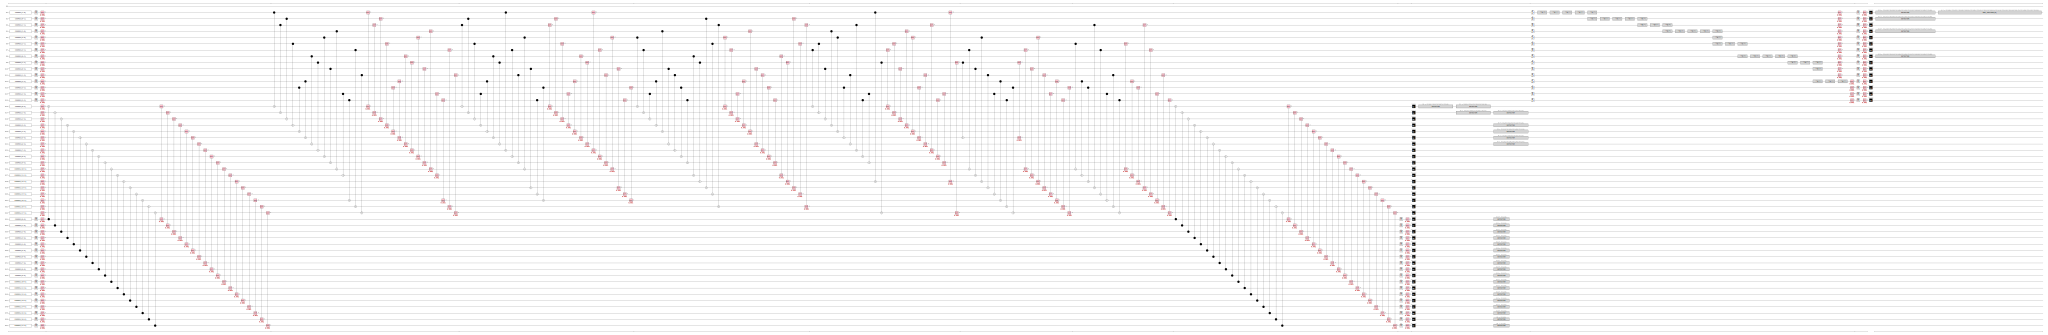

In [12]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [get_bit(i,0) + 2 * get_bit(i,2), get_bit(i,1) + 2 * get_bit(i,3)])
    for j in range(16,34):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        CNOT_list = []
        if i == 0:
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
        CNOT_list = []
        for j in range(18):
            qubit = QRM_Z_CHECKS[j][i]
            if qubit != 0:
                CNOT_list.extend([qubit, 16 + j])
        circuit.append('CNOT', CNOT_list)
        circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
        circuit.append('TICK')
        if i == 5:
            CNOT_list = []
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(34,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for mc in QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # apply transversal gates
    circuit.append('S', list(range(1, 16)))
    for i in range(1, 16):
        for j in range(10):
            if C[i - 1, j] == 1:
                #conditioned Z gate
                circuit.append('CZ', [stim.target_rec(j - 36), i])
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

In [27]:
import stim
import numpy as np

def postselected_rates_via_dem(c: stim.Circuit, shots: int, obs_index: int = 0, seed: int | None = None):
    """
    Computes:
      - accept_rate: fraction of shots where all detectors are 0
      - logical_error_rate_conditional: P(observable flipped | accepted)
      - logical_error_rate_unconditional: P(observable flipped)

    Uses the detector error model so 'observable flip' means 'differs from ideal'.
    """
    if c.num_observables <= obs_index:
        raise ValueError(f"Circuit has {c.num_observables} observables; requested index {obs_index}.")

    # Build and sample the detector error model (DEM).
    dem = c.detector_error_model()
    ds = dem.compile_sampler(seed=seed)

    # Detection events (0/1); observable flips (0/1)
    dets = ds.sample(shots)                          # shape: (shots, dem.num_detectors)
    obs_flips = ds.sample_observables(shots)         # shape: (shots, dem.num_observables)

    # Post-selection: accept iff all detectors are 0
    accept_mask = np.all(dets == 0, axis=1)
    accepted = int(np.sum(accept_mask))
    accept_rate = accepted / shots

    # Error = observable flipped relative to noiseless value
    flips = obs_flips[:, obs_index].astype(np.uint8)

    if accepted > 0:
        logical_err_cond = float(np.mean(flips[accept_mask]))
    else:
        logical_err_cond = float('nan')

    logical_err_uncond = float(np.mean(flips))

    return {
        'total_shots': shots,
        'accepted_shots': accepted,
        'accept_rate': accept_rate,
        'logical_error_rate_conditional': logical_err_cond,
        'logical_error_rate_unconditional': logical_err_uncond,
    }

shots = 100_000
res = postselected_rates_via_dem(circuit, shots=shots, obs_index=0, seed=1)
print(res)

ValueError: The circuit contains non-deterministic observables.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['L0', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords L0 > output_image.svg

This was discovered while analyzing qubit initialization into |0> at the start of the circuit on:
    qubit 7 [coords (3, 1)]

The collapse anti-commuted with these detectors/observables:
    L0

The backward-propagating error sensitivity for L0 was:
    Z1 [coords (1, 0)]
    Z2 [coords (0, 1)]
    Z3 [coords (1, 1)]
    Z4 [coords (2, 0)]
    Z5 [coords (3, 0)]
    Z6 [coords (2, 1)]
    Y7 [coords (3, 1)]
    Z8 [coords (0, 2)]
    Z9 [coords (1, 2)]
    Z10 [coords (0, 3)]
    Y11 [coords (1, 3)]
    Z12 [coords (2, 2)]
    Y13 [coords (3, 2)]
    Y14 [coords (2, 3)]
    Y15 [coords (3, 3)]
    Z16 [coords (0, 5)]
    Z18 [coords (2, 5)]
    Z20 [coords (4, 5)]
    Z22 [coords (6, 5)]
    Z24 [coords (8, 5)]
    Z25 [coords (9, 5)]